In [1]:
import os
from tqdm.notebook import tqdm
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

### Load all simulation complexes

In [ ]:
data_dir = "./E6/E6_VIA_MD"
xtc1_filename="prot_E6_via_complex_VIA_cluster_center_traj.xtc"
tpr_filename="prot_E6_via_complex_VIA_cluster_center.tpr"

xtc2_filename="prot_E6_via_complex_VIA_gppmd_extend_cluster_center.part0002.xtc"

E6_sildenafil_complex= mda.Universe(os.path.join(data_dir, tpr_filename),[os.path.join(data_dir, xtc1_filename),os.path.join(data_dir, xtc2_filename)], continuous=True)


In [ ]:
data_dir = "./E6AP/E6AP_VIA_MD"
xtc_filename="prot_E6E6AP_VIA_complex_VIA_cluster_center_traj.xtc"
tpr_filename="prot_E6E6AP_VIA_complex_VIA_cluster_center.xtc"

E6AP_sildenafil_complex= mda.Universe(os.path.join(data_dir, tpr_filename), os.path.join(data_dir, xtc_filename))


In [5]:
data_dir = "./E6_E6AP/E6E6AP_VIA_MD"
xtc_filename="prot_E6E6AP_VIA_complex_VIA_cluster_center_traj.xtc"
tpr_filename="prot_E6E6AP_VIA_complex_VIA_cluster_center.tpr"

E6E6AP_sildenafil_complex= mda.Universe(os.path.join(data_dir, tpr_filename), os.path.join(data_dir, xtc_filename))

In [8]:
import pandas as pd
sildenafil_df = pd.DataFrame()

### Calculate all RMSD values and load in a dataframe

In [9]:
from MDAnalysis.analysis import rms
# Build the DataFrame directly by running the RMSD analysis for each complex
for universe in [E6_sildenafil_complex, E6AP_sildenafil_complex, E6E6AP_sildenafil_complex]:
    R_local = rms.RMSD(universe, universe, select='backbone', ref_frame=0)
    R_local.run(verbose=True)
    times = R_local.results.rmsd[:, 1]
    rmsd = R_local.results.rmsd[:, 2]
    # Create a DataFrame to hold the RMSD and later RMSF and Rg results
    complex_name = universe.trajectory.filename.split('/')[-2]  # Extract the complex name from the filename
    sildenafil_df[complex_name + '_Time'] = times
    sildenafil_df[complex_name + '_RMSD'] = rmsd


  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

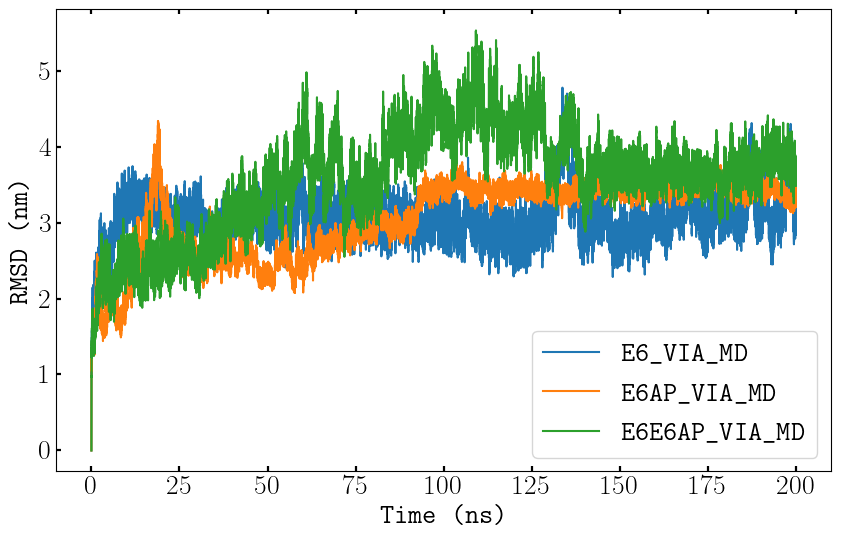

In [14]:
# Prepare and display the plot.
plt.figure(figsize=(10, 6))
plt.plot(sildenafil_df['E6_VIA_MD_Time']/1000, sildenafil_df['E6_VIA_MD_RMSD'], label='E6_VIA_MD')
plt.plot(sildenafil_df['E6AP_VIA_MD_Time']/1000, sildenafil_df['E6AP_VIA_MD_RMSD'], label='E6AP_VIA_MD')
plt.plot(sildenafil_df['E6E6AP_VIA_MD_Time']/1000, sildenafil_df['E6E6AP_VIA_MD_RMSD'], label='E6E6AP_VIA_MD')
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (nm)')
plt.legend()
plt.show()

### Calculate all RMSF and load in a dataframe

In [18]:
import pandas as pd
from MDAnalysis.analysis import rms

for universe in [E6_sildenafil_complex, E6AP_sildenafil_complex, E6E6AP_sildenafil_complex]:
    R_local = rms.RMSF(universe.select_atoms('backbone and name CA')).run(verbose=True)
    rmsf = R_local.results.rmsf
    # Create a DataFrame to hold the RMSF results
    complex_name = universe.trajectory.filename.split('/')[-2]  # Extract the complex name from the filename
    sildenafil_df[complex_name + '_RMSF'] = [rmsf] * len(sildenafil_df)
    sildenafil_df[complex_name + '_Resid'] = [universe.select_atoms('backbone and name CA').resids] * len(sildenafil_df)




  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

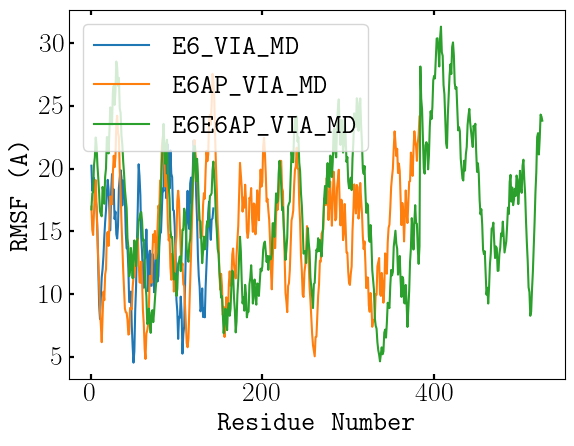

In [23]:
# Prepare and display the plot.
for complex_name in ['E6_VIA_MD', 'E6AP_VIA_MD', 'E6E6AP_VIA_MD']:
    plt.plot(sildenafil_df[complex_name + '_Resid'][0], sildenafil_df[complex_name + '_RMSF'][0], label=complex_name)
plt.xlabel('Residue Number')
plt.ylabel('RMSF (A)')
plt.legend()

### Calculate all Radii of Gyration and load in a dataframe 

In [24]:
from tqdm.notebook import tqdm
for universe in [E6_sildenafil_complex, E6AP_sildenafil_complex, E6E6AP_sildenafil_complex]:
    group = universe.select_atoms('protein')
    times = []
    rg = []
    for ts in tqdm(universe.trajectory):
        times.append(ts.time)
        rg.append(group.radius_of_gyration()/10)
    complex_name = universe.trajectory.filename.split('/')[-2]  # Extract the complex name from the filename    
    sildenafil_df[complex_name + 'Rg_Times'] = times
    sildenafil_df[complex_name + 'Rg'] = rg

  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

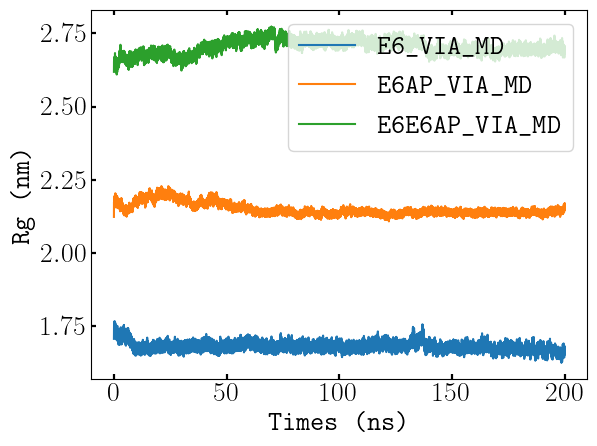

In [27]:
# Prepare and display the plot.
for complex_name in ['E6_VIA_MD', 'E6AP_VIA_MD', 'E6E6AP_VIA_MD']:
    plt.plot(sildenafil_df[complex_name + 'Rg_Times']/1000, sildenafil_df[complex_name + 'Rg'], label=complex_name)
plt.xlabel('Times (ns)')
plt.ylabel('Rg (nm)')
plt.legend()

### Number of hydrogen bonds between protein and ligand

In [6]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd

# Select the atoms for the analysis

# Create the HydrogenBondAnalysis object
hbs = HBA(universe=E6_sildenafil_complex,
          between=[
        ["protein", "resname VIA"],
        [ "resname VIA","protein"]
        ], # for protein-water hbonds
        d_h_cutoff=50.0, #This is set to an absurdly high value, which basically ignores this distance cutoff
        d_a_cutoff=3.5, d_h_a_angle_cutoff=30.0, #these are cutoffs used by GROMACS
    update_selections=False
    )
hbs.run(verbose=True)

  0%|          | 0/100001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:775: UserWarning: No hydrogen bonds were found given angle of 30.0 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYS and name O) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HIS and name ND1) or (resname HIS and name NE2) or (resname HIS and name O) or (resname ILE and name O) or (resname LEU and name O) or (re

In [7]:
for bond_idx in hbs.count_by_ids():
    donor_idx, hydrogen_idx, acceptor_idx, nframes = bond_idx
    donor_atom = E6_sildenafil_complex.atoms[donor_idx]
    hydrogen_atom = E6_sildenafil_complex.atoms[hydrogen_idx]
    acceptor_atom = E6_sildenafil_complex.atoms[acceptor_idx]
    hbond = f"{donor_atom.resid}-{donor_atom.resname}-{hydrogen_atom.name}::{acceptor_atom.name} , {nframes/ len(E6_sildenafil_complex.trajectory):.2%} frames"
    print(hbond)

107-GLN-HE21::O2 , 10.46% frames
107-GLN-HE22::O2 , 10.45% frames
107-GLN-HE21::O3 , 9.53% frames
107-GLN-HE22::O3 , 9.22% frames
129-ARG-HE::O2 , 2.48% frames
71-SER-HG::O3 , 1.51% frames
129-ARG-HH21::O2 , 1.35% frames
129-ARG-HH22::O2 , 0.93% frames
131-ARG-HH22::O2 , 0.57% frames
131-ARG-HH12::O2 , 0.56% frames
131-ARG-HH11::O2 , 0.54% frames
131-ARG-HH21::O2 , 0.53% frames
131-ARG-HH12::O3 , 0.33% frames
131-ARG-HH11::O3 , 0.33% frames
131-ARG-HH22::O3 , 0.09% frames
131-ARG-HH21::O3 , 0.08% frames
131-ARG-HE::O2 , 0.07% frames
74-SER-HG::O3 , 0.01% frames


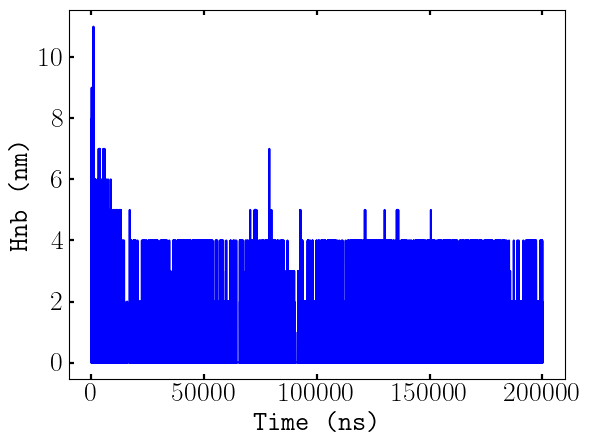

In [8]:
times = hbs.times
nhb = hbs.count_by_time()
E6_sildenafil_df['Nhb'] = nhb
nhb_df = pd.DataFrame({'Time': times, 'Nhb': nhb})
plt.plot(times, nhb, label='Nhb', color='blue')
plt.yticks([0,2,4,6,8,10])
plt.xlabel('Time (ns)')
plt.ylabel('Hnb (nm)')
plt.show()

The large number of hbonds in the beginning might be misleading, indicating that the same bond keeps getting counted multiple times due to shifting acceptor/donor residues.

### Hydrogen bonds from GROMACS

GROMACS hbond-legacy gave a better more sensible result for the hydrogen bonds, consistent with the VMD visualization where the ligand was rigidly bonded.

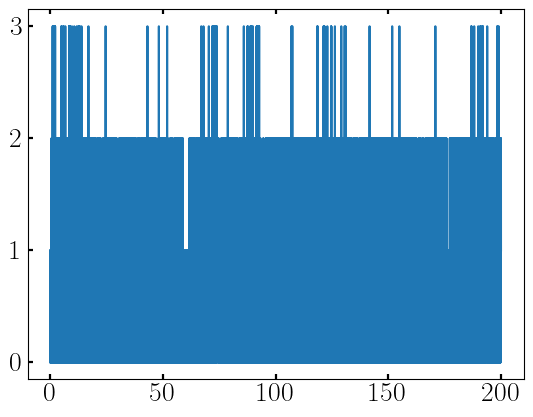

In [16]:
import numpy as np

gmx_hbondnum_file1 = os.path.join(data_dir, "hbnum_gromacs.xvg")
gmx_hbondnum_file2 = os.path.join(data_dir, "hbnum_extend.xvg")
with open(gmx_hbondnum_file1, 'r') as f:
    valid_lines = [line for line in f if not line.startswith(('#', '@'))]
data1 = np.loadtxt(valid_lines)
times1 = data1[:, 0]/1000
nhb1 = data1[:,1]

with open(gmx_hbondnum_file2, 'r') as f:
    valid_lines = [line for line in f if not line.startswith(('#', '@'))]
data2 = np.loadtxt(valid_lines)
times2 = data2[:, 0]/1000
nhb2 = data2[:,1]

E6_sildenafil_df['times_gmx'] = np.concatenate((times1, times2[1:]))
E6_sildenafil_df['Nhb_gmx'] = np.concatenate((nhb1, nhb2[1:]))

plt.plot(E6_sildenafil_df['times_gmx'], E6_sildenafil_df['Nhb_gmx'])

In [33]:
sildenafil_df.to_pickle("sildenafil_df.pkl")

In [17]:
participating_resids = [71, 74, 107, 129, 131] 
extra_ticks = [73, 107, 130]

### Plot everything

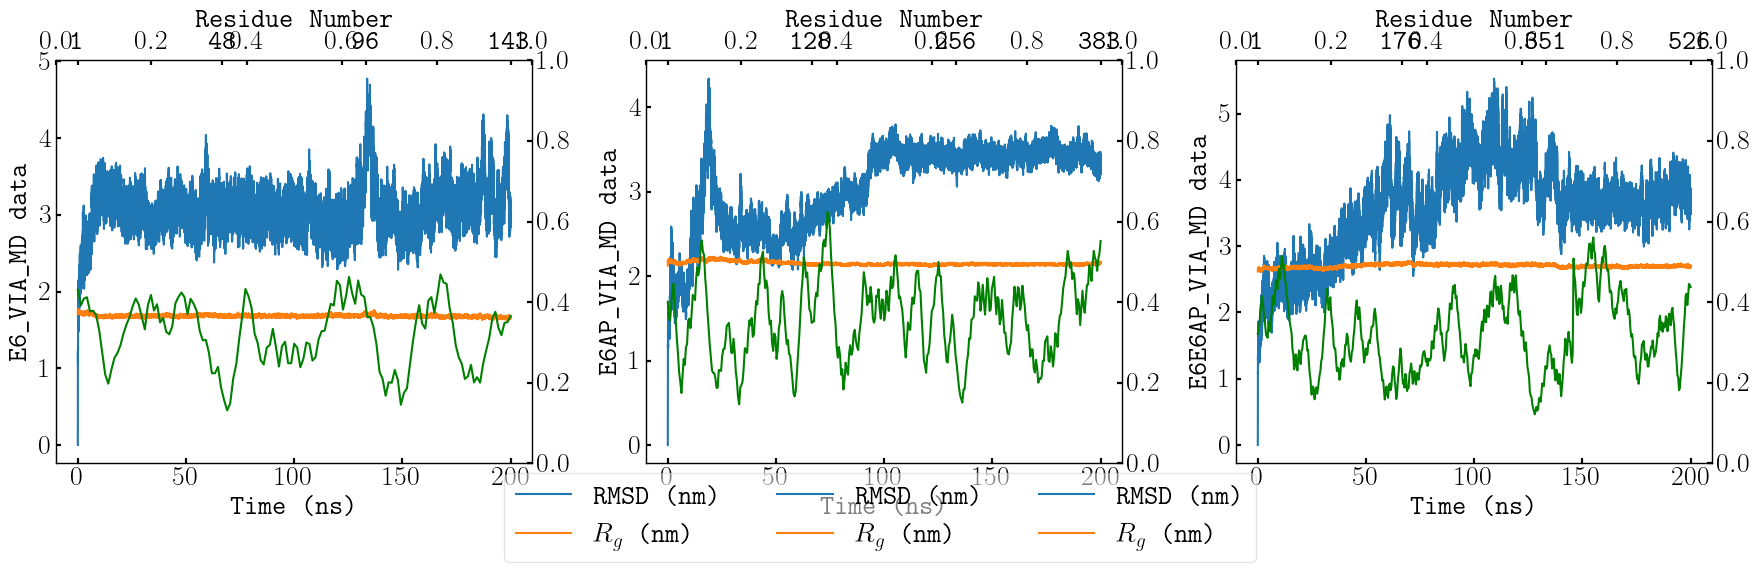

In [31]:
complexes = ['E6_VIA_MD', 'E6AP_VIA_MD', 'E6E6AP_VIA_MD']

# Create a figure with 3 panels arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for ax, comp in zip(axes, complexes):
    # Left y-axis: Plot RMSD and Rg
    ax.set_xlabel('Time (ns)')
    # Get RMSD data: For each complex we have a specific time and RMSD column
    time_col = comp + '_Time'
    rmsd_col = comp + '_RMSD'
    ax.plot(sildenafil_df[time_col]/1000, sildenafil_df[rmsd_col],
            color='tab:blue', label='RMSD (nm)')
    
    # Choose the corresponding Rg columns
    if comp == 'E6_VIA_MD':
        rg_time_col = 'E6_VIA_MDRg_Times'
        rg_col = 'E6_VIA_MDRg'
    elif comp == 'E6AP_VIA_MD':
        rg_time_col = 'E6AP_VIA_MDRg_Times'
        rg_col = 'E6AP_VIA_MDRg'
    else:
        rg_time_col = 'E6E6AP_VIA_MDRg_Times'
        rg_col = 'E6E6AP_VIA_MDRg'
    ax.plot(sildenafil_df[rg_time_col]/1000, sildenafil_df[rg_col],
            color='tab:orange', label=r'$R_g$ (nm)')
    ax.set_ylabel(f'{comp} data')
    
    # Create secondary y-axis for hydrogen bonds (only available for E6_VIA_MD)
    #ax2 = ax.twinx()
    #if comp == 'E6_VIA_MD':
    #    ax2.set_yticks([0, 1, 2, 3])
    #    ax2.set_ylabel(r'$N_{hb}$')
    #    ax2.plot(sildenafil_df["times_gmx"], sildenafil_df['Nhb_gmx'],
    #             color='gray', label=r'$N_{hb}$', alpha=0.4)
    
    # Create a top x-axis for RMSF data
    ax_top = ax.twiny()
    # Extract RMSF and residue data stored as lists in the first row
    rmsf_data = np.array(sildenafil_df[comp + '_RMSF'].iloc[0])
    resid_data = np.array(sildenafil_df[comp + '_Resid'].iloc[0])
    ax_top.plot(resid_data, rmsf_data/10, label="RMSF (nm)", color='green')
    ax_top.set_xlabel('Residue Number')
    # Set ticks using np.linspace and extra ticks already defined in a previous cell
    ticks = np.linspace(resid_data[0], resid_data[-1], 4)
    #ticks = np.sort(np.append(ticks, extra_ticks))
    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(["{:.0f}".format(x) for x in ticks])
    # Draw vertical dashed lines for participating residues (assumed defined already)
    ymax = ax_top.get_ylim()[1]
    #for resid in participating_resids:
    #    # Find the index of the residue in resid_data
    #    idx = np.where(resid_data == resid)[0][0]
    #    ax_top.vlines(x=resid, ymin=rmsf_data[idx]/10, ymax=ymax,
    #                  color='green', linestyle='--', linewidth=1.5)
    
    # Remove individual legends to create unified legend later from handles of current axes
    ax.legend().remove()
    #ax2.legend().remove()
    ax_top.legend().remove()

# Collect handles and labels from the three panels for a unified legend
handles, labels = [], []
for ax in axes:
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.twinx().get_legend_handles_labels()
    h3, l3 = ax.twiny().get_legend_handles_labels()
    handles += h1 + h2 + h3
    labels += l1 + l2 + l3

fig.legend(handles, labels, loc='lower center', ncol=3, framealpha=0.5)
plt.tight_layout(rect=[0, 0.05, 1, 1])
#plt.savefig('sildenafil_complex_panels.svg', dpi=300, bbox_inches='tight')
plt.show()

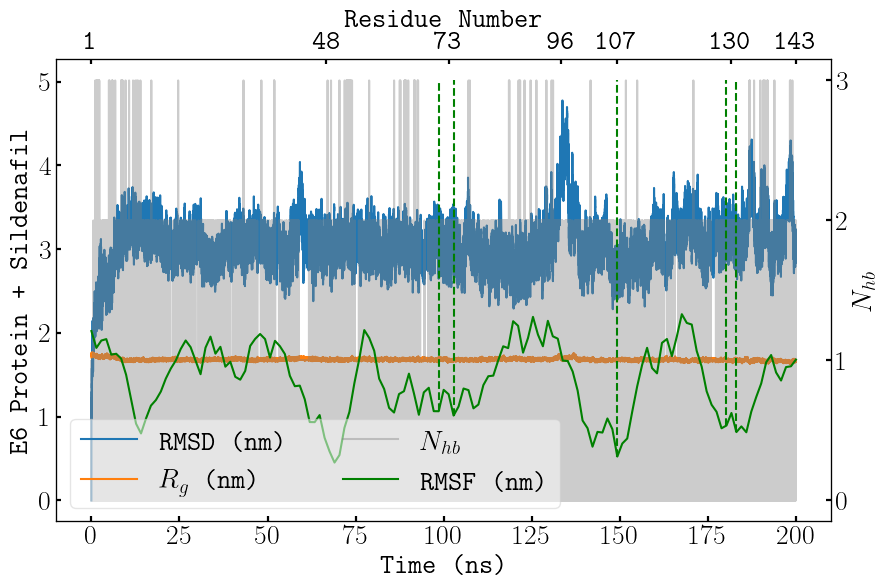

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot RMSD and Rg on the left y-axis
ax1.set_xlabel('Time (ns)')
#ax1.set_ylabel('RMSD / Rg (nm)', color='tab:blue')
ax1.plot(E6_sildenafil_df.index/1000, E6_sildenafil_df['RMSD'], color='tab:blue', label='RMSD (nm)')
ax1.plot(E6_sildenafil_df.index/1000, E6_sildenafil_df['Rg'], color='tab:orange', label=r'$R_g$ (nm)')
ax1.set_ylabel('E6 Protein + Sildenafil')
ax1.legend(loc='upper left')

# Create secondary y-axis for Nhb
ax2 = ax1.twinx()
ax2.set_yticks([0,1, 2, 3])
ax2.set_ylabel(r'$N_{hb}$')
ax2.plot(E6_sildenafil_df["times_gmx"], E6_sildenafil_df['Nhb_gmx'], color='gray', label=r'$N_{hb}$', alpha=0.4)
ax2.legend(loc='upper right')

ax_top = ax1.twiny()
    
ax_top.plot(resids, rmsf/10,label="RMSF (nm)", color='green')
ax_top.set_xlabel('Residue Number')
ticks = np.linspace(resids[0], resids[-1], 4)
ticks = np.sort(np.append(ticks, extra_ticks))
ax_top.set_xticks(ticks)
ax_top.set_xticklabels(["{:.0f}".format(x) for x in ticks])
ax_top.legend(loc='lower right')
ymax = ax_top.get_ylim()[1]
for resid in participating_resids:
    idx = np.where(resids == resid)[0][0]
    ax_top.vlines(x=resid, ymin=rmsf[idx]/10, ymax=ymax, color='green', linestyle='--', linewidth=1.5)


# Remove individual legends to create a single legend
ax1.get_legend().remove()
ax2.get_legend().remove()
ax_top.get_legend().remove()

# Collect handles and labels from all axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax_top.get_legend_handles_labels()
all_handles = handles1 + handles2 + handles3
all_labels = labels1 + labels2 + labels3

# Create a unified legend
plt.legend(all_handles, all_labels, loc='lower left', ncol=2)
leg = plt.gca().get_legend()
leg.get_frame().set_alpha(0.5)
plt.savefig('E6_sildenafil_analysis.svg', dpi=300, bbox_inches='tight')
plt.show()

## Refined Hydrogen bond analysis

In [19]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd

# Select the atoms for the analysis

# Create the HydrogenBondAnalysis object
hbs_refined = HBA(universe=E6_sildenafil_complex,
          between=
        ["resid 107 or resid 129 or resid 131", "resname VIA"],
        d_h_cutoff=50.0, #This is set to an absurdly high value, which basically ignores this distance cutoff
        d_a_cutoff=3.5, d_h_a_angle_cutoff=30.0, #these are cutoffs used by GROMACS
    update_selections=False
    )
hbs_refined.run(verbose=True)

  0%|          | 0/100001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:775: UserWarning: No hydrogen bonds were found given angle of 30.0 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYS and name O) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HIS and name ND1) or (resname HIS and name NE2) or (resname HIS and name O) or (resname ILE and name O) or (resname LEU and name O) or (re

In [20]:
hbs_refined.count_by_type()

array([['ARG:N2', 'VIA:o', '7863'],
       ['GLN:N', 'VIA:o', '39656']], dtype='<U21')

In [21]:
hbond_probs_dict = {}
for bond_idx in hbs_refined.count_by_ids():
    donor_idx, hydrogen_idx, acceptor_idx, nframes = bond_idx
    donor_atom = E6_sildenafil_complex.atoms[donor_idx]
    hydrogen_atom = E6_sildenafil_complex.atoms[hydrogen_idx]
    acceptor_atom = E6_sildenafil_complex.atoms[acceptor_idx]
    hbond = f"({donor_atom.resid}-{donor_atom.resname}){donor_atom.name}--{hydrogen_atom.name}::{acceptor_atom.name}(VIA)"
    hbond_probs_dict[hbond] = nframes / len(E6_sildenafil_complex.trajectory)

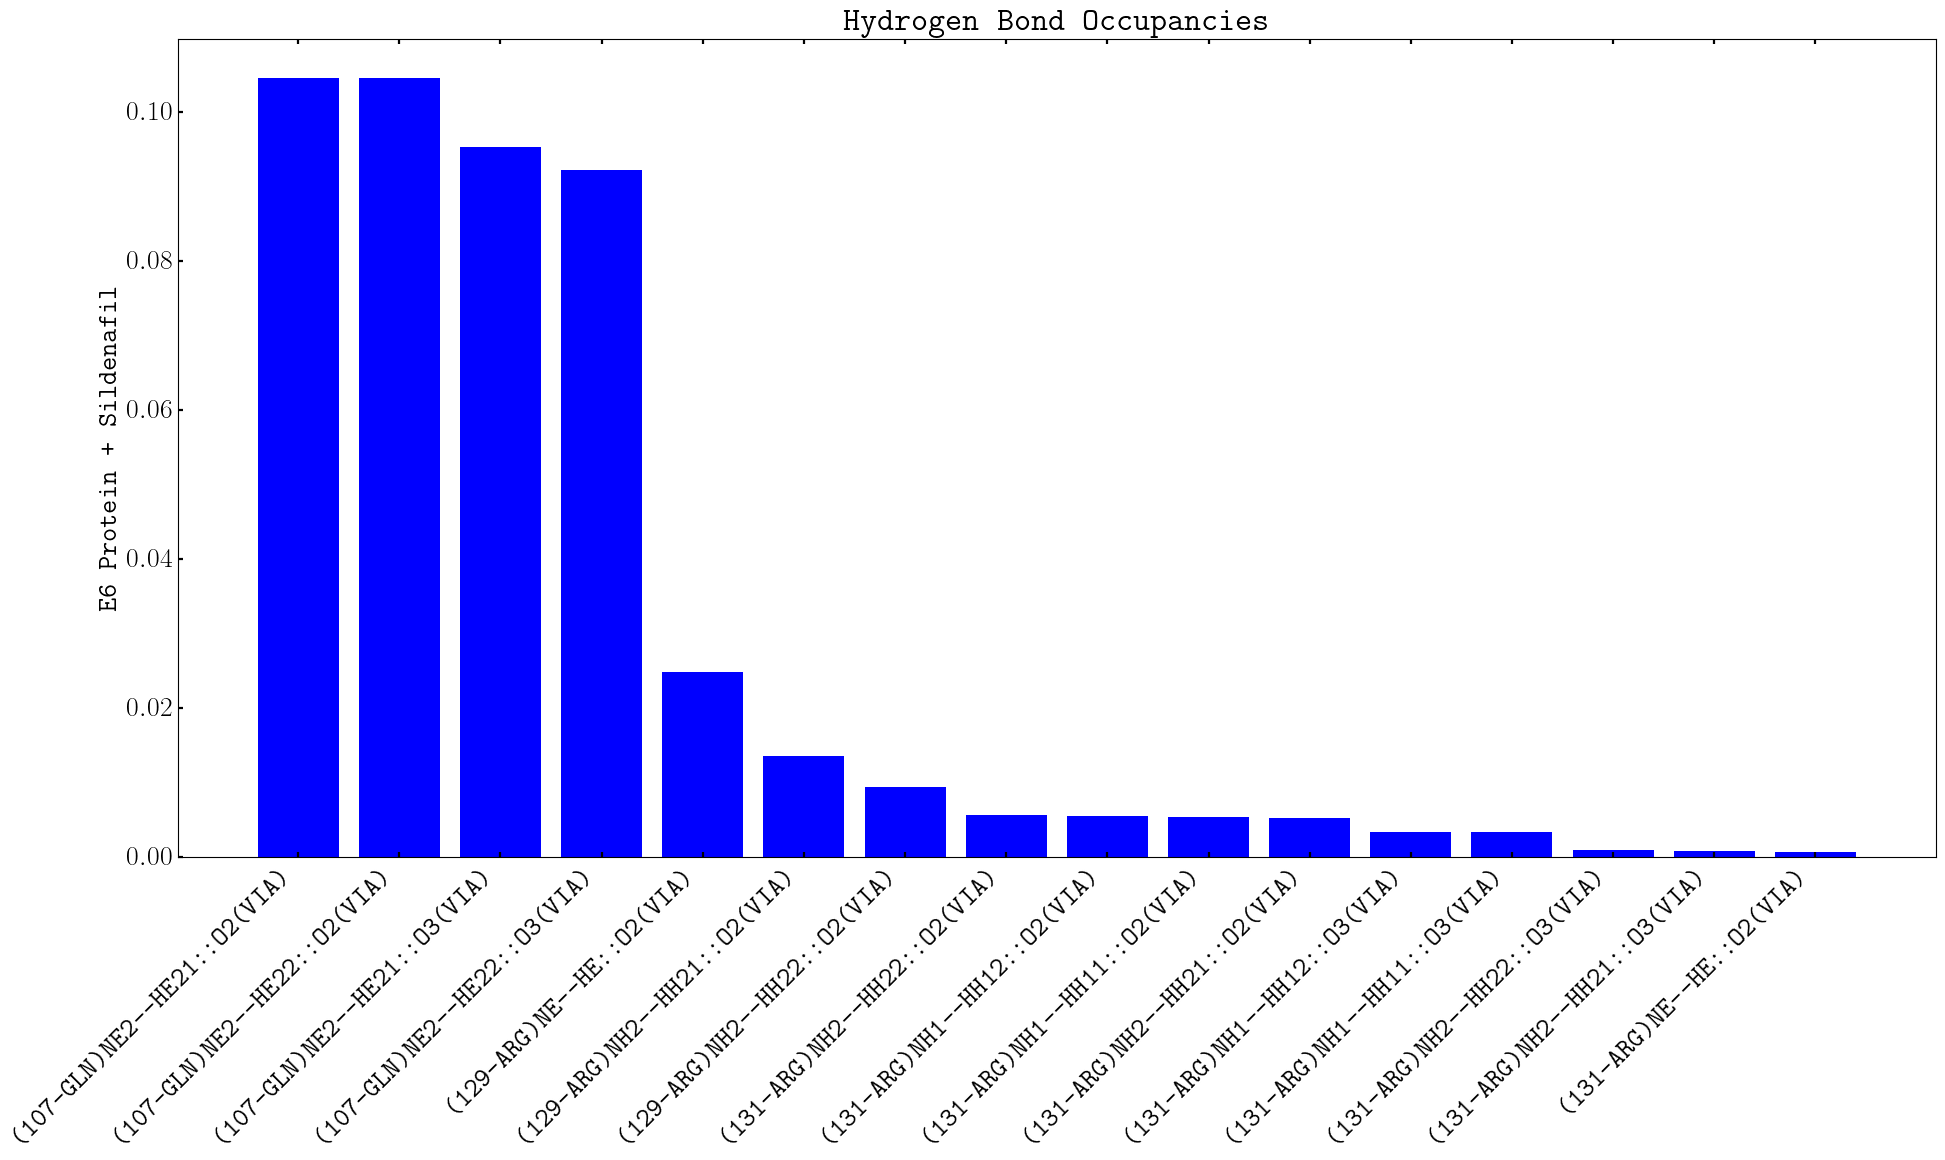

In [22]:
keys = list(hbond_probs_dict.keys())
values = list(hbond_probs_dict.values())

plt.figure(figsize=(20,12))
plt.bar(keys, values, color='blue')
plt.ylabel("E6 Protein + Sildenafil")
plt.title("Hydrogen Bond Occupancies")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('E6_sildenafil_hbond_occupancies.svg', dpi=300, bbox_inches='tight')
plt.show()